In [1]:
# Load libraries

# # Plotting utils 
import datetime
import glob
import os
import pickle
import time
import warnings
from datetime import date, timedelta
import Ngl
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util
from cartopy.util import add_cyclic_point
import matplotlib as matplotlib
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import metpy.calc as mpc
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from matplotlib.dates import DateFormatter
from metpy.units import units
from metpy import interpolate
from metpy.calc import vertical_velocity
from mpl_toolkits.axes_grid1 import make_axes_locatable

warnings.filterwarnings('ignore')


In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

In [3]:

def preprocess(ds):
    ds         = cesm_correct_time(ds)
    return ds

## Read in data 

In [4]:
mainDir = '/glade/scratch/mdfowler/archive/'

limONcase  = 'FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_cam6_3_112_gustsOFF_CDNlimON.002'
limOFFcase = 'FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_cam6_3_112_gustsOFF_noCDNlim.001'

files_on  = np.sort(glob.glob(mainDir+limONcase+'/atm/hist/*cam.h3.*'))
files_off = np.sort(glob.glob(mainDir+limOFFcase+'/atm/hist/*cam.h3.*'))

DS_limOn = xr.open_mfdataset(files_on,  preprocess=preprocess, concat_dim='time', 
                            combine='nested', decode_times=False, 
                            data_vars='minimal')

DS_limOff = xr.open_mfdataset(files_off,  preprocess=preprocess, concat_dim='time', 
                            combine='nested', decode_times=False, 
                            data_vars='minimal')


In [5]:
len(DS_limOn.time.values)

4321

In [6]:
print('cdnLim_on Times: ', DS_limOn.time.values[0], DS_limOn.time.values[-1])
print('cdnLim_off Times:', DS_limOff.time.values[0], DS_limOff.time.values[-1])


cdnLim_on Times:  0001-01-01 00:00:00 0001-03-31 23:45:00
cdnLim_off Times: 0001-01-01 00:00:00 0001-03-31 23:45:00


In [11]:

print(DS_limOn.time.values[100])
print(DS_limOn.time.values[101])

0001-01-03 01:45:00
0001-01-03 02:15:00


In [47]:
DS_limOn.load()
DS_limOff.load()

<xarray.Dataset>
Dimensions:       (lat: 192, lon: 288, lev: 58, ilev: 59, trop_cld_lev: 58,
                   time: 4321, nbnd: 2)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.3 357.5 358.8
  * lev           (lev) float64 3.018 5.445 9.087 14.25 ... 983.2 991.2 997.5
  * ilev          (ilev) float64 2.055 3.98 6.909 11.27 ... 987.4 995.1 1e+03
  * trop_cld_lev  (trop_cld_lev) float64 3.018 5.445 9.087 ... 983.2 991.2 997.5
  * time          (time) object 0001-01-01 00:00:00 ... 0001-03-31 23:45:00
Dimensions without coordinates: nbnd
Data variables: (12/25)
    w             (lat) float64 3.382e-05 0.0002705 ... 0.0002705 3.382e-05
    hyam          (lev) float64 0.003018 0.005445 0.009087 ... 0.0003615 0.0
    hybm          (lev) float64 0.0 0.0 0.0 0.0 ... 0.9726 0.9821 0.9908 0.9975
    hyai          (ilev) float64 0.002055 0.00398 0.006909 ... 0.000723 0.0 0.0
    hybi          (ilev) float64 0.0 0.0 0.0 0.0 ... 0.9775 0.9866 0.9951 1.0
    date          (time) int32 10101 10101 10101 10101 ... 10331 10331 10401
    ...            ...
    n2ovmr        (time) float64 3.159e-07 3.159e-07 ... 3.155e-07 3.155e-07
    f11vmr        (time) float64 2.615e-10 2.615e-10 ... 2.614e-10 2.614e-10
    f12vmr        (time) float64 5.425e-10 5.425e-10 ... 5.42e-10 5.42e-10
    sol_tsi       (time) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    nsteph        (time) int32 0 1 2 3 4 5 6 ... 4315 4316 4317 4318 4319 4320
    U10           (time, lat, lon) float32 1.407 1.407 1.407 ... 13.15 13.15
Attributes:
    interp_type:       bilinear
    interp_outputgri:  equally spaced with poles
    Conventions:       CF-1.0
    source:            CAM
    case:              FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_cam...
    logname:           mdfowler
    host:              cheyenne3
    initial_file:      FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_cam...
    topography_file:   /glade/campaign/cesm/cesmdata/inputdata/atm/cam/topo/s...
    model_doi_url:     not_set
    time_period_freq:  minute_30

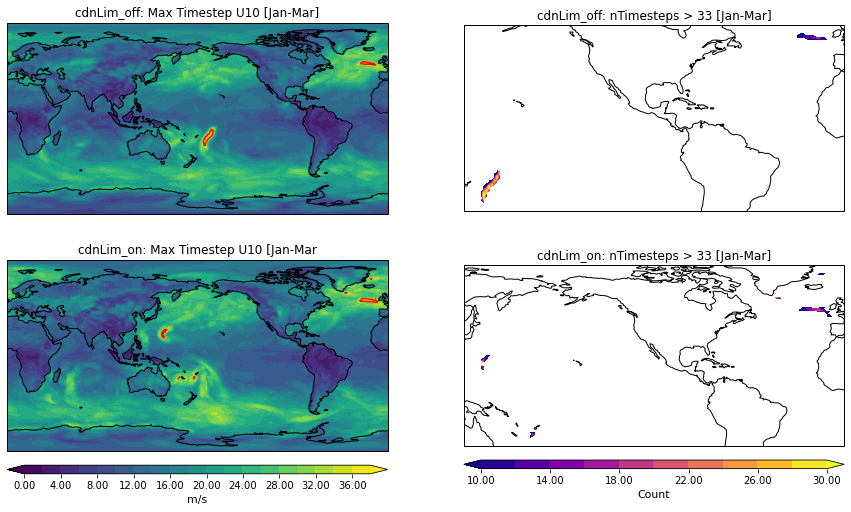

In [29]:
fig,axs= plt.subplots(2,2, figsize=(15,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axs = axs.ravel()

cLims = np.arange(0,40,2)

axs[0].contourf(DS_limOff.lon.values, DS_limOff.lat.values, DS_limOff.U10.max(dim='time').values, 
                cLims, extend = 'both',transform=ccrs.PlateCarree())
axs[0].set_title('cdnLim_off: Max Timestep U10 [Jan-Mar]')
axs[0].coastlines()
## Add line contours too 
CS = axs[0].contour(DS_limOff.lon.values, DS_limOff.lat.values, 
                     DS_limOff.U10.max(dim='time').values, [0, 34], 
               colors='r',  transform=ccrs.PlateCarree())


c = axs[2].contourf(DS_limOn.lon.values, DS_limOn.lat.values, DS_limOn.U10.max(dim='time').values, 
                cLims, extend = 'both',transform=ccrs.PlateCarree())
# Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.015])
cbar        = plt.colorbar(c, orientation='horizontal',cax=cbar_ax,format='%.2f')
cbar.set_label('m/s',fontsize=11)
axs[2].set_title('cdnLim_on: Max Timestep U10 [Jan-Mar')
axs[2].coastlines()
## Add line contours too 
CS = axs[2].contour(DS_limOn.lon.values, DS_limOn.lat.values, 
                     DS_limOn.U10.max(dim='time').values, [0, 34], 
                     colors='r',  transform=ccrs.PlateCarree())


#### Plot counts
cLims = np.arange(10,32,2)

arr_Off = DS_limOff.where(DS_limOff.U10>33).count(dim='time').U10
# mask = arr_Off.where(arr_Off==0).values 
# mask[np.where(mask==0)] = np.nan
axs[1].contourf(DS_limOff.lon.values, DS_limOff.lat.values, arr_Off.where(arr_Off.values>0).values, 
                cLims, cmap='plasma', extend = 'both',transform=ccrs.PlateCarree())
axs[1].set_title('cdnLim_off: nTimesteps > 33 [Jan-Mar]')
axs[1].coastlines()

arr_On = DS_limOn.where(DS_limOn.U10>33).count(dim='time').U10
# mask2 = arr_On.where(arr_On==0).values
# mask2[np.where(mask2==0)] = np.nan
c=axs[3].contourf(DS_limOn.lon.values, DS_limOn.lat.values, arr_On.where(arr_On.values>0).values, 
                cLims, cmap='plasma', extend = 'both',transform=ccrs.PlateCarree())
axs[3].set_title('cdnLim_on: nTimesteps > 33 [Jan-Mar]')
axs[3].coastlines()
# Add colorbar
ax_position = axs[3].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.015])
cbar        = plt.colorbar(c, orientation='horizontal',cax=cbar_ax,format='%.2f')
cbar.set_label('Count',fontsize=11)


# axs[1].set_global()
# axs[3].set_global()

Text(0.5, 0, 'Number of timesteps limiter activated')

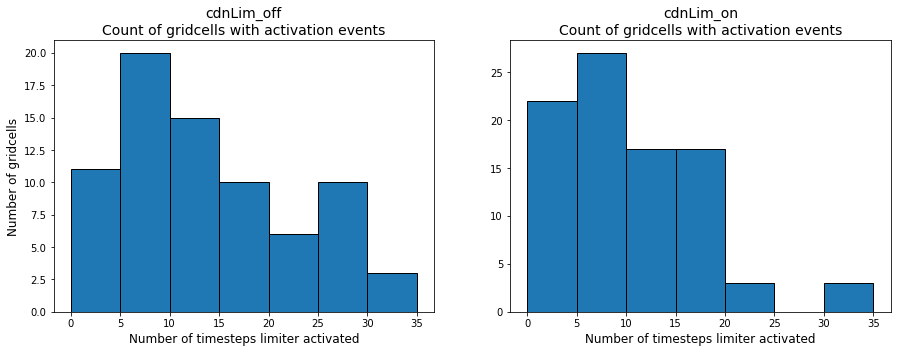

In [34]:
fig,axs = plt.subplots(1,2, figsize=(15,5))
axs = axs.ravel()

bins = np.arange(0,40,5)
numel = len(DS_limOff.lat.values)*len(DS_limOff.lon.values)

axs[0].hist(arr_Off.where(arr_Off.values>0).values.reshape(numel,1), bins, edgecolor='k')
axs[1].hist(arr_On.where(arr_On.values>0).values.reshape(numel,1), bins, edgecolor='k')

axs[0].set_title('cdnLim_off\nCount of gridcells with activation events', fontsize=14)
axs[0].set_xlabel('Number of timesteps limiter activated', fontsize=12)
axs[0].set_ylabel('Number of gridcells', fontsize=12)

axs[1].set_title('cdnLim_on\nCount of gridcells with activation events', fontsize=14)
axs[1].set_xlabel('Number of timesteps limiter activated', fontsize=12)



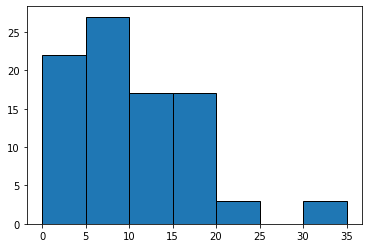

In [41]:
a = plt.hist(arr_On.where(arr_On.values>0).values.reshape(numel,1), bins, edgecolor='k')

In [42]:
a[0].sum()

89.0

(array([11.,  9., 13., 12.,  8.,  3.,  3.,  3.,  8.,  5.]),
 array([ 1. ,  4.1,  7.2, 10.3, 13.4, 16.5, 19.6, 22.7, 25.8, 28.9, 32. ]),
 <BarContainer object of 10 artists>)

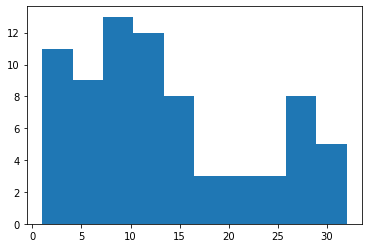

In [30]:
plt.hist((arr_Off.where(arr_Off.values>0).values).reshape( len(arr_Off.lat.values)*len(arr_Off.lon.values), 1 ))

In [27]:
np.nanmax(arr_Off.where(arr_Off.values>0).values)

32.0

In [28]:
np.nanmax(arr_On.where(arr_On.values>0).values)

35.0

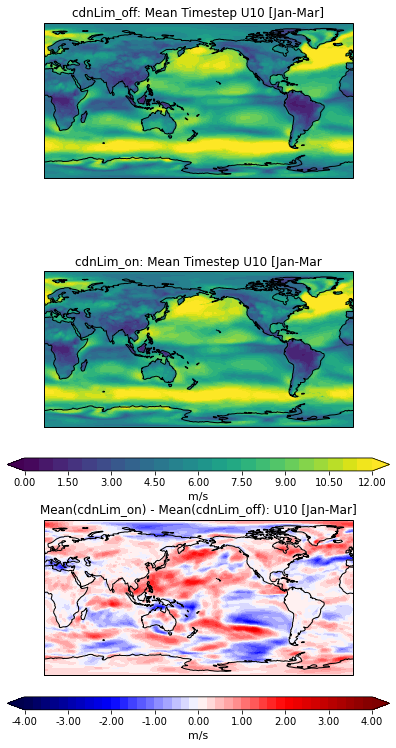

In [45]:
fig,axs= plt.subplots(3,1, figsize=(15,12), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axs = axs.ravel()

cLims = np.arange(0,12.5,0.5)
axs[0].contourf(DS_limOff.lon.values, DS_limOff.lat.values, DS_limOff.U10.mean(dim='time').values, 
                cLims, extend = 'both',transform=ccrs.PlateCarree())
axs[0].set_title('cdnLim_off: Mean Timestep U10 [Jan-Mar]')
axs[0].coastlines()


c = axs[1].contourf(DS_limOn.lon.values, DS_limOn.lat.values, DS_limOn.U10.mean(dim='time').values, 
                cLims, extend = 'both',transform=ccrs.PlateCarree())
# Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.015])
cbar        = plt.colorbar(c, orientation='horizontal',cax=cbar_ax,format='%.2f')
cbar.set_label('m/s',fontsize=11)
axs[1].set_title('cdnLim_on: Mean Timestep U10 [Jan-Mar')
axs[1].coastlines()

cLims = np.arange(-4,4.2, 0.2)
# c = axs[2].contourf(DS_limOn.lon.values, DS_limOn.lat.values, (DS_limOn.U10-DS_limOff.U10).mean(dim='time').values, 
c = axs[2].contourf(DS_limOn.lon.values, DS_limOn.lat.values, (DS_limOn.U10.mean(dim='time')-DS_limOff.U10.mean(dim='time')).values, 
                cLims, cmap='seismic', extend = 'both',transform=ccrs.PlateCarree())
# Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.015])
cbar        = plt.colorbar(c, orientation='horizontal',cax=cbar_ax,format='%.2f')
cbar.set_label('m/s',fontsize=11)
axs[2].set_title('Mean(cdnLim_on) - Mean(cdnLim_off): U10 [Jan-Mar]')
axs[2].coastlines()

fig.subplots_adjust(hspace=0.6)